In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gifify import gifify
from tqdm import tqdm

# make default font size larger
plt.rcParams.update({"font.size": 32})

# make default line width larger
plt.rcParams.update({"axes.linewidth": 4})
plt.rcParams.update({"lines.linewidth": 4})
plt.rcParams.update({"grid.linewidth": 4})

# make default figure size larger
plt.rcParams.update({"figure.figsize": (10, 8)})

# make default markers larger
plt.rcParams.update({"lines.markersize": 20})

# Sample NxN matrix $J$ with stats:
$\mathbb{E}[J] = 0$

$\mathbb{E}[J_{ij}^2] = 1/N$

$\mathbb{E}[J_{ij}J_{ji}] = \tau / N, \forall i \neq j$


In [2]:
def sample_matrix(N=50, num_samples=1000, tau=0.5, print_info=True):
    """
    Generate num_samples number of random NxN asymmetric matrix.

    The correlation between J_ij and J_ji is tau.
    The mean of each element is 0.
    The variance of each element is 1.

    Returns:
        J: np.ndarray of shape (N, N, num_samples)
        mean_diff: maximum difference between the mean of J and 0
        std_diff: maximum difference between the std of J and 1
        corr_diff: maximum difference between the correlation of J and tau
        tol: tolerance for the differencek
    """
    # generate a random matrix
    A = np.random.randn(N, N, num_samples) / np.sqrt(N)
    At = np.transpose(A, (1, 0, 2))

    # some quick maffs to get the desired correlation
    a = np.sqrt((1 + tau))
    b = np.sqrt((1 - tau))
    alpha = 0.5 * (a + b)
    beta = 0.5 * (a - b)
    J = alpha * A + beta * At

    # resample the diagonal elements
    # J[np.diag_indices(N)] = np.random.randn(N, num_samples) / np.sqrt(N)
    J[np.diag_indices(N)] = 0

    # compute empirical statistics
    Jt = np.transpose(J, (1, 0, 2))
    means = np.mean(J, axis=2)
    stds = np.mean(J * J, axis=2)
    corrs = np.mean(J * Jt, axis=2)
    expected = (tau + np.eye(N) * (-tau)) / N

    tol = 10 * np.sqrt(1 / num_samples)
    mean_diff = np.max(np.abs(means))
    std_diff = np.max(np.abs(stds - 1.0 / N * (1 - np.eye(N))))
    corr_diff = np.max(np.abs(corrs - expected))

    if print_info:
        print(
            f"mean_diff={mean_diff:.2e}, std_diff={std_diff:.2e}, "
            + f"corr_diff={corr_diff:.2e}, tol={tol:.2e}"
        )

    return J, mean_diff, std_diff, corr_diff, tol

Checking num_samples=10
mean_diff=1.73e-01, std_diff=3.90e-02, corr_diff=3.04e-02, tol=3.16e+00
Checking num_samples=21
mean_diff=1.28e-01, std_diff=3.75e-02, corr_diff=2.55e-02, tol=2.18e+00
Checking num_samples=46
mean_diff=6.86e-02, std_diff=2.30e-02, corr_diff=1.35e-02, tol=1.47e+00
Checking num_samples=100
mean_diff=4.78e-02, std_diff=1.29e-02, corr_diff=8.41e-03, tol=1.00e+00
Checking num_samples=215
mean_diff=3.38e-02, std_diff=8.53e-03, corr_diff=7.81e-03, tol=6.82e-01
Checking num_samples=464
mean_diff=2.61e-02, std_diff=4.88e-03, corr_diff=4.39e-03, tol=4.64e-01
Checking num_samples=1000
mean_diff=1.66e-02, std_diff=3.37e-03, corr_diff=2.36e-03, tol=3.16e-01
Checking num_samples=2154
mean_diff=1.15e-02, std_diff=2.43e-03, corr_diff=1.57e-03, tol=2.15e-01
Checking num_samples=4641
mean_diff=6.97e-03, std_diff=1.45e-03, corr_diff=1.24e-03, tol=1.47e-01
Checking num_samples=10000
mean_diff=4.35e-03, std_diff=1.12e-03, corr_diff=6.55e-04, tol=1.00e-01


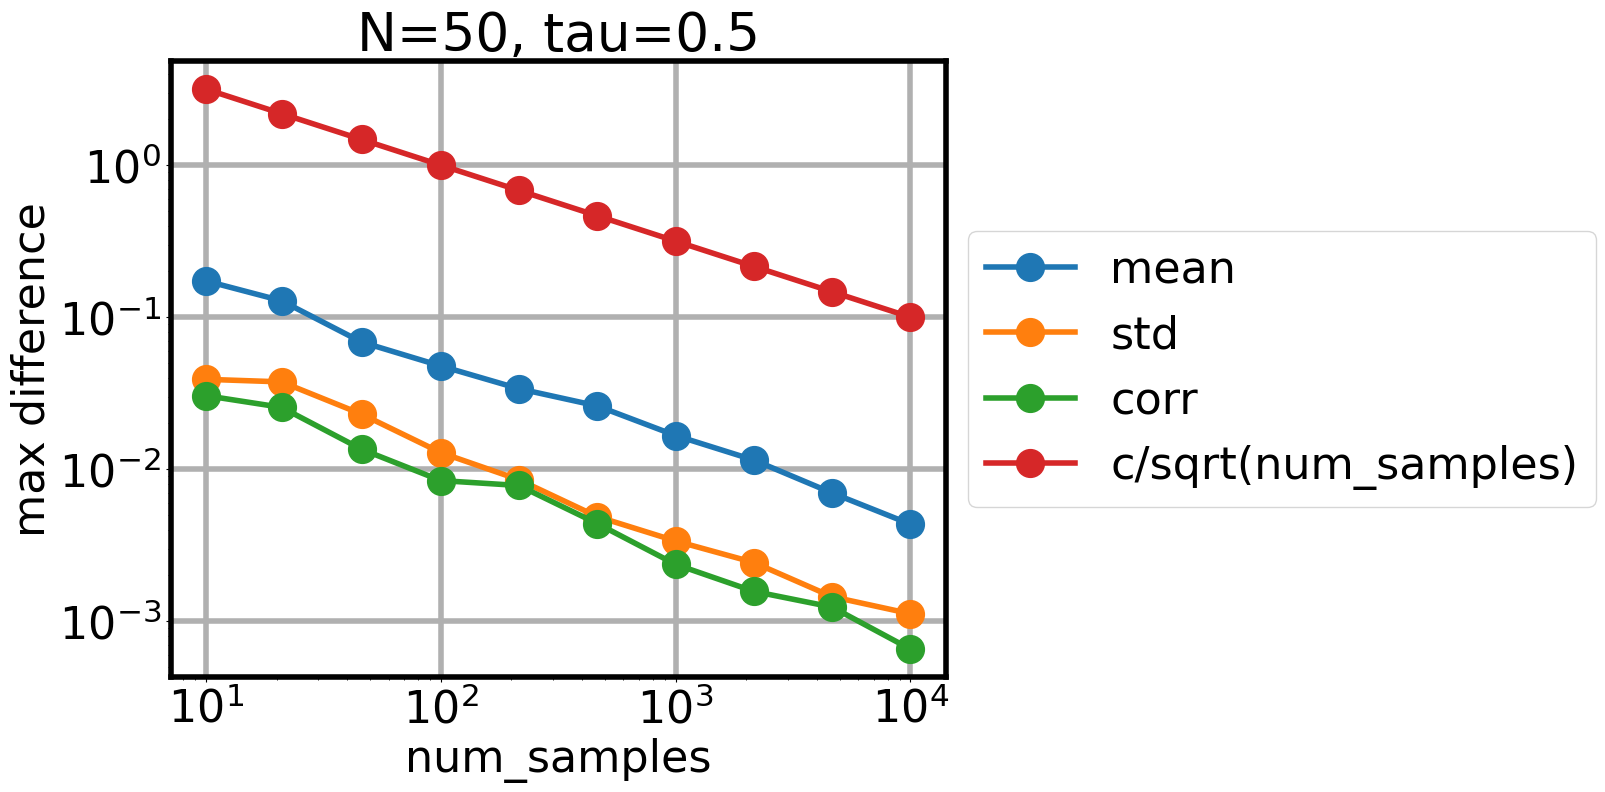

In [3]:
# check stats
mean_diffs = []
std_diffs = []
corr_diffs = []
tols = []

N = 50
tau = 0.5
num_samples = np.logspace(1, 4, 10).astype(int)
for num_sample in num_samples:
    print(f"Checking num_samples={num_sample}")
    J, mean_diff, std_diff, corr_diff, tol = sample_matrix(
        num_samples=num_sample,
        N=N,
        tau=tau,
    )
    mean_diffs.append(mean_diff)
    std_diffs.append(std_diff)
    corr_diffs.append(corr_diff)
    tols.append(tol)

plt.figure()
plt.grid()
plt.plot(num_samples, mean_diffs, "o-", label="mean")
plt.plot(num_samples, std_diffs, "o-", label="std")
plt.plot(num_samples, corr_diffs, "o-", label="corr")
plt.plot(num_samples, tols, "o-", label="c/sqrt(num_samples)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("num_samples")
plt.ylabel("max difference")
plt.title(f"N={N}, tau={tau}")
# plot legend outside of the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Compute spectrum and histogram on complex plane

In [4]:
def spectrum(J):
    """
    Compute the spectrum of the NxN matrix J.

    Returns:
        spectrum: np.ndarray of shape (N, num_samples)
    """
    # compute the eigenvalues
    spectrum = np.linalg.eigvals(J.transpose(2, 0, 1))
    return spectrum

In [5]:
def plot_spectrum(spectrum, bins=100, tau=0.0, extent=2.0, colorbar=True):
    real = np.real(spectrum).reshape(-1)
    imag = np.imag(spectrum).reshape(-1)

    edges = np.linspace(-extent, extent, bins, endpoint=True)

    H, xedges, yedges = np.histogram2d(real, imag, bins=edges, density=True)

    x = xedges[:-1] + 0.5 * (xedges[1] - xedges[0])
    y = yedges[:-1] + 0.5 * (yedges[1] - yedges[0])

    xx, yy = np.meshgrid(x, y)

    # contour plot of the histogram
    plt.contourf(xx, yy, H.T, levels=100, cmap="viridis")
    # plt.xlabel("real")
    # plt.ylabel("imag")
    plt.title(f"Spectrum of J, tau={tau:.2f}, N={N}")
    if colorbar:
        plt.colorbar()

    return H, xedges, yedges

In [6]:
def plot_ellipse(tau):
    """
    Plot the ellipse with the given tau.
    """
    a = 1 + tau
    b = 1 - tau
    theta = np.linspace(0, 2 * np.pi, 100)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    plt.plot(x, y, "r", label="ellipse")

In [7]:
# sample matrix
tau = 0.5
N = 300
num_samples = 100
J = sample_matrix(N=N, num_samples=num_samples, tau=tau)[0]

mean_diff=2.50e-02, std_diff=2.53e-03, corr_diff=1.91e-03, tol=1.00e+00


In [8]:
# compute spectrum
spec = spectrum(J)

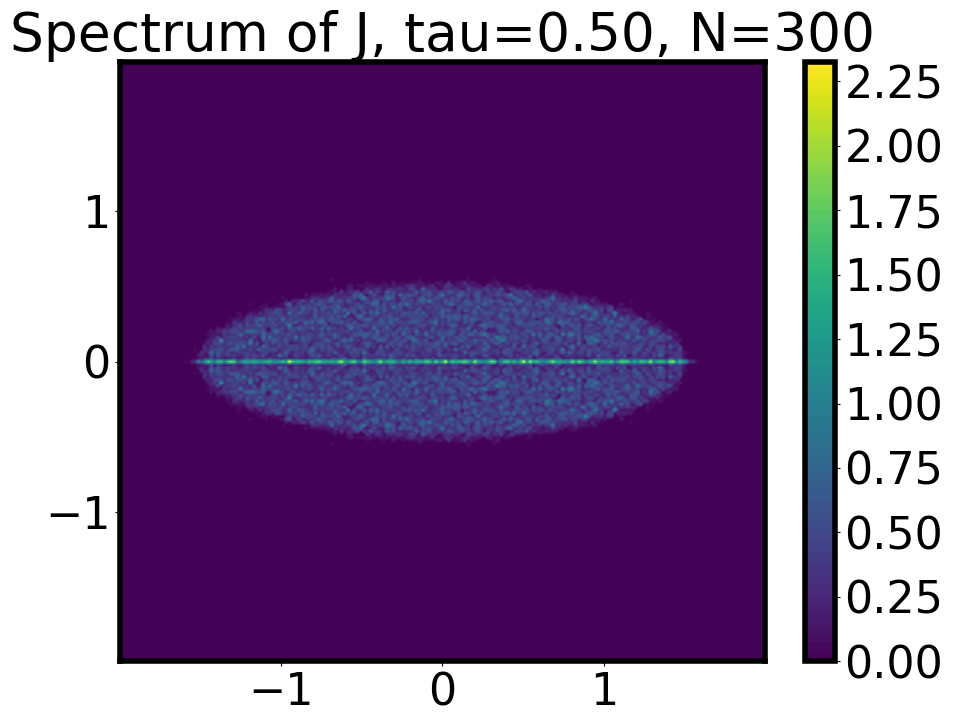

In [9]:
# plot spectrum
bins = 200
plt.figure()
H, xedges, yedges = plot_spectrum(spec, bins=bins, tau=tau, extent=2.0)
plt.tight_layout()
plt.savefig(f"spectrum_tau={tau}_N={N}.png")
plt.show()

In [10]:
Ns = [50, 100, 200, 400, 800]
taus = [0.0, 0.5, 0.9, 1.0]

specs = {}
for tau in taus:
    for N in Ns:
        print(f"Calculating spectra tau={tau}, N={N}")
        J = sample_matrix(N=N, num_samples=num_samples, tau=tau)[0]
        spec = spectrum(J)
        specs[(tau, N)] = spec

Calculating spectra tau=0.0, N=50
mean_diff=4.58e-02, std_diff=1.12e-02, corr_diff=6.81e-03, tol=1.00e+00
Calculating spectra tau=0.0, N=100
mean_diff=4.14e-02, std_diff=5.46e-03, corr_diff=4.36e-03, tol=1.00e+00
Calculating spectra tau=0.0, N=200
mean_diff=2.92e-02, std_diff=3.80e-03, corr_diff=2.04e-03, tol=1.00e+00
Calculating spectra tau=0.0, N=400
mean_diff=2.39e-02, std_diff=1.95e-03, corr_diff=1.17e-03, tol=1.00e+00
Calculating spectra tau=0.0, N=800
mean_diff=2.00e-02, std_diff=9.73e-04, corr_diff=6.64e-04, tol=1.00e+00
Calculating spectra tau=0.5, N=50
mean_diff=5.43e-02, std_diff=1.06e-02, corr_diff=8.04e-03, tol=1.00e+00
Calculating spectra tau=0.5, N=100
mean_diff=3.79e-02, std_diff=5.88e-03, corr_diff=4.64e-03, tol=1.00e+00
Calculating spectra tau=0.5, N=200
mean_diff=3.25e-02, std_diff=3.33e-03, corr_diff=2.68e-03, tol=1.00e+00
Calculating spectra tau=0.5, N=400
mean_diff=2.28e-02, std_diff=1.95e-03, corr_diff=1.44e-03, tol=1.00e+00
Calculating spectra tau=0.5, N=800
mean

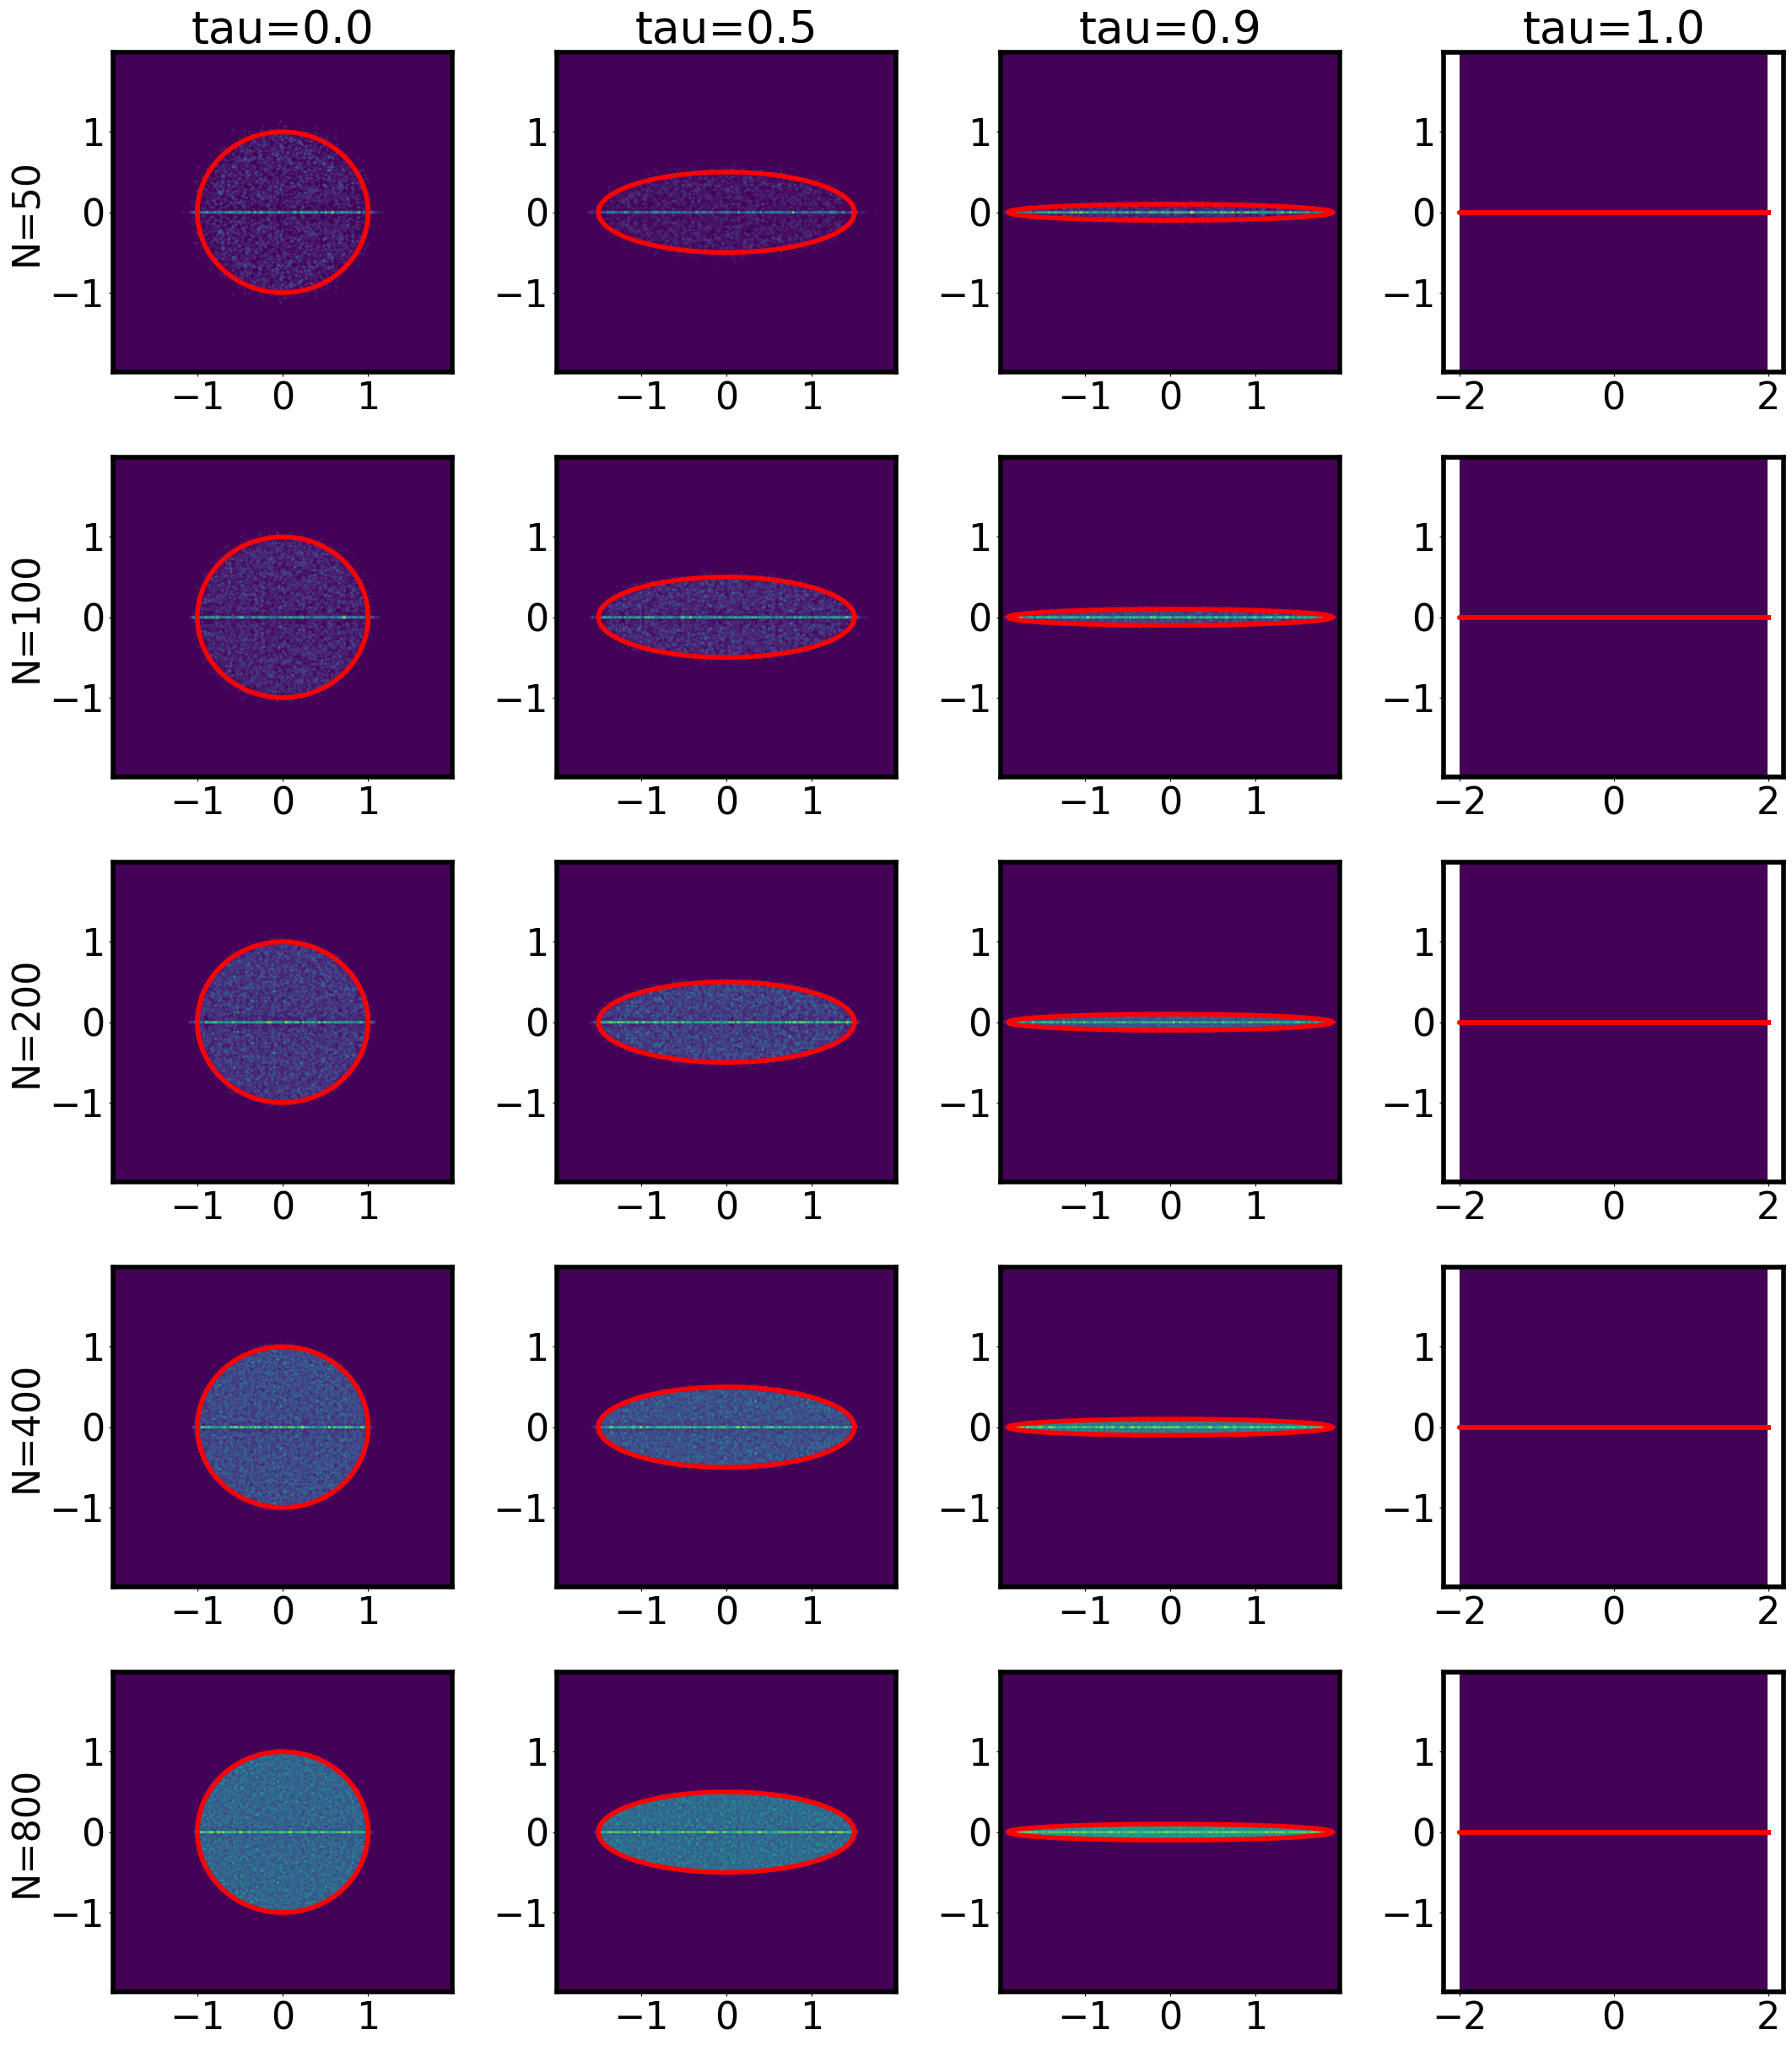

In [11]:
fig_dir = "/Users/rajat/Dropbox/Apps/Overleaf/AP229 Final Project/figs/"
extension = "eps"
os.makedirs(f"{fig_dir}/{extension}", exist_ok=True)
plt.subplots(len(Ns), len(taus), figsize=(len(taus) * 5 + 2, len(Ns) * 5))
for n, N in enumerate(Ns):
    for i, tau in enumerate(taus):
        plt.subplot(len(Ns), len(taus), n * len(taus) + i + 1)
        if i == 0:
            plt.ylabel(f"N={N}")
        H, xedges, yedges = plot_spectrum(
            specs[(tau, N)],
            bins=bins,
            tau=tau,
            extent=2.0,
            colorbar=False,
        )
        plot_ellipse(tau)
        if n == 0:
            plt.title(f"tau={tau}")
        else:
            plt.title("")

plt.tight_layout()
plt.savefig(f"{fig_dir}/{extension}/spectra_num_samples={num_samples}.{extension}")
plt.show()

# Vary $\tau$

100%|████████████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


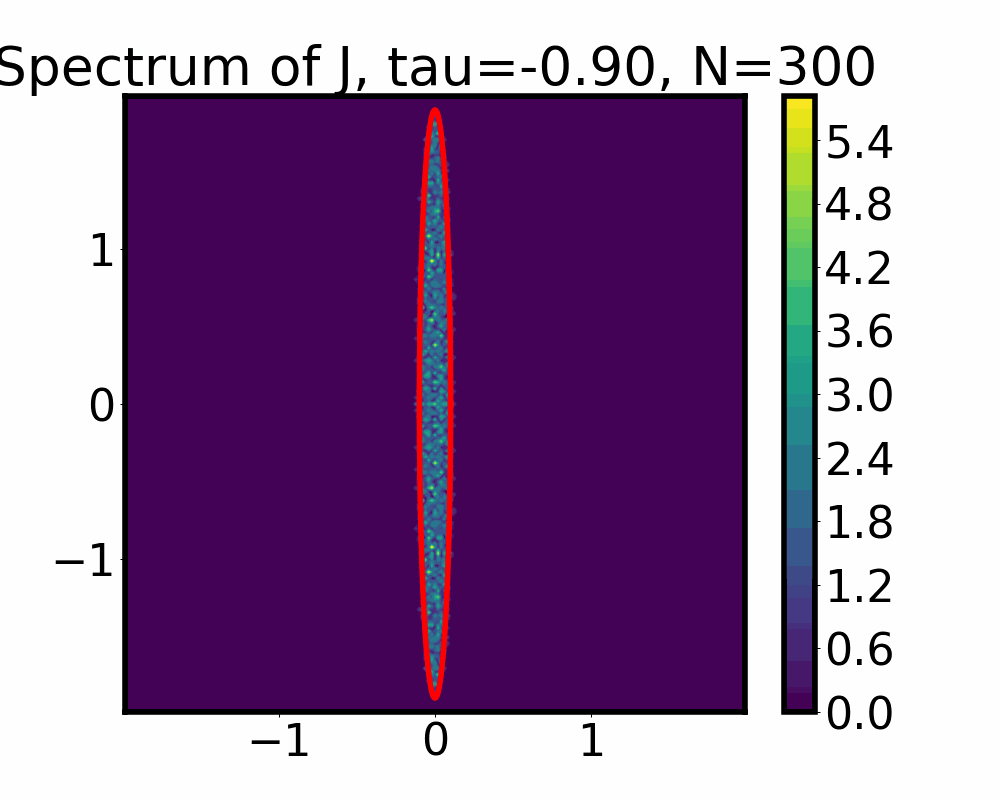

In [12]:
num_samples = 10
N = 300
taus = np.linspace(-0.9, 0.9, 50)
for tau in gifify(tqdm(taus), filename="spectrum.gif"):
    plt.figure()
    J = sample_matrix(N=N, num_samples=num_samples, tau=tau, print_info=False)[0]
    spec = spectrum(J)
    H, xedges, yedges = plot_spectrum(spec, bins=bins, tau=tau, extent=2.0)
    plot_ellipse(tau)